- Is the share of female Nobel prize winners becoming more equal over time?
- From which country origin most Nobel prize winners?
- How does your country rank with respect to the number of Nobel prize winners in history?
- What is the trend in age with respect to Nobel prize winners (per prize category)?
- Which generations are generating most Nobel prize winners?

Training: https://learn.datacamp.com/projects/nobel-winners  
Inspiration: https://www.kaggle.com/kenjee  
Documentation: https://seaborn.pydata.org/  

# Table of Contents

## Notebook Setup
* [Packages](#Packages)
* [Source Data](#Source-Data)

## Data Preprocessing
* [Add feature Decade](#Add-feature-Decade)
* [Add feature Age](#Add-feature-Age)
* [Add feature Generation](#Add-feature-Generation)
* [Adjusting for duplicate records](#Duplicate-records)

## Data Visualization
* Nobel prizes by [Sex](#Nobel-prizes-by-Sex)
* Nobel prizes by [Country](#Nobel-prizes-by-Country)
* Nobel prizes by [Age](#Nobel-prizes-by-Age)
* Nobel prizes by [Generation](#Nobel-prizes-by-Generation)


# Notebook Setup

#### Packages

In [2]:
pip install geopandas

     |████████████████████████████████| 1.1 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 26.5 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 8.0 MB 11.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os # operating system (files)
import numpy as np  # Linear algebra
import pandas as pd  # Data processing
import geopandas as gpd  # Geometry data for plotting data on (world) maps 
import seaborn as sns  # Data visualization
import matplotlib.pyplot as plt  # Data visualization
from matplotlib.ticker import PercentFormatter  # Format axis in percentages
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Scale axis of (world) maps

#### Source Data

In [17]:
df_nobel = pd.read_csv('archive.csv')
display(df_nobel.head(n=3))

,Year,Category,Prize,Motivation,Prize Share,Laureate ID,Laureate Type,Full Name,Birth Date,Birth City,Birth Country,Sex,Organization Name,Organization City,Organization Country,Death Date,Death City,Death Country
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,160,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Male,Berlin University,Berlin,Germany,1911-03-01,Berlin,Germany
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1/1,569,Individual,Sully Prudhomme,1839-03-16,Paris,France,Male,NaN,NaN,NaN,1907-09-07,Châtenay,France
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1/1,293,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Male,Marburg University,Marburg,Germany,1917-03-31,Marburg,Germany


In [18]:
def null_count_by_column(df):
    """Lists number of missing values per column if n missing values > 0"""
    print(f'DataFrame shape: {df.shape}', end='\n\n')
    col_missing_values = (df.isnull().sum()).sort_values(ascending=False)
    print(f'DataFrame feature # missing values: \n{col_missing_values[col_missing_values > 0]}')


print(null_count_by_column(df_nobel))

DataFrame shape: (969, 18)

DataFrame feature # missing values: 
Death City              370
Death Country           364
Death Date              352
Organization Country    253
Organization City       253
Organization Name       247
Motivation               88
Birth Date               29
Birth City               28
Birth Country            26
Sex                      26
dtype: int64
None


# Data Preprocessing

#### Add feature Decade
Adding a feature to the dataset indicating the the respective 'Decade' per record based on the 'Year' the Nobel prize was awarded.

In [19]:
df_nobel['Decade'] = df_nobel['Year'].apply(lambda x: np.floor(x / 10) * 10).astype(int)
print(f'Unique values for added Decade in the dataset: {df_nobel.Decade.unique()}')

Unique values for added Decade in the dataset: [1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010]


#### Add feature Age
Adding a feature to the dataset indicating the respective 'Age' per record based on 'Birth Date' and the 'Year' the Nobel prize was awarded. In addition each record is allocated to an 'Age_Group' based on the calculated 'Age'

In [20]:
df_nobel['Birth Date'] = pd.to_datetime(df_nobel['Birth Date'], errors='coerce')
df_nobel['Age'] = df_nobel['Year'] - df_nobel['Birth Date'].dt.year
df_nobel['Age_Group'] = pd.cut(df_nobel['Age'], bins=[0, 18, 30, 64, 99],
                               labels=['Youth', 'Young Adult', 'Adult', 'Senior'])

print('Relative share of Nobel prize winners per added Age_Group:')
display(df_nobel['Age_Group'].value_counts(normalize=True, sort=False).to_frame())

Relative share of Nobel prize winners per added Age_Group:


,Age_Group
Youth,0.001066
Young Adult,0.001066
Adult,0.655650
Senior,0.342217


#### Add feature Generation
Adding a feature to the dataset indicating the respective 'Generation' per record based on 'Birth Date'.

In [21]:
# Source: https://en.wikipedia.org/wiki/Generation#/media/File:Generation_timeline.svg
generations = ['Ancient', 'Lost Generation', 'Greatest Generation', 'Silent Generation', 'Boomers I', 'Boomers II', 'Generation X', 'Millenials (Y)', 'Generation Z', 'Generation Alpha']
age_bins = [min(df_nobel['Birth Date'].dt.year), 1883, 1900, 1927, 1945, 1955, 1965, 1980, 1996, 2012, 2021]
df_nobel['Generation'] = pd.cut(df_nobel['Birth Date'].dt.year, age_bins, labels=generations)
display(df_nobel['Generation'].value_counts(normalize=True, sort=False).to_frame())

,Generation
Ancient,0.202775
Lost Generation,0.122732
Greatest Generation,0.323372
Silent Generation,0.243330
Boomers I,0.076841
Boomers II,0.023479
Generation X,0.006403
Millenials (Y),0.000000
Generation Z,0.001067
Generation Alpha,0.000000


#### Duplicate records
Individual winners of the nobel prize are identified by 'Laureate ID'. Paul Modrich is listed twice for receiving a nobel prize in the same 'Category' in the same 'Year', listing a different 'Organization Name'. These records of Paul Modrich indicate he was related to 2 organizations when winning the nobel prize, not winning the nobel prize twice. Hence these records will not be considered when analyzing the number of nobel prizes. Marie Curie has been awarded the nobel prize twice, once in 1903 for Physics and once in 1911 for Chemistry. When analyzing the number of nobel prizes we do consider these records as individual awards.

In [22]:
df_nobel_prizes = df_nobel.drop_duplicates(subset=['Year', 'Category', 'Laureate ID'])
print(f'Number of (possibly shared) Nobel Prizes handed out between 1901 and 2016: {len(df_nobel_prizes)}')

Number of (possibly shared) Nobel Prizes handed out between 1901 and 2016: 911


Saving CSV file for data visualization in Tableau

In [42]:
from pathlib import Path  
filepath = Path('BigDataProject/out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_nobel.to_csv(filepath)  

# Data Visualization

#### Nobel prizes by Sex

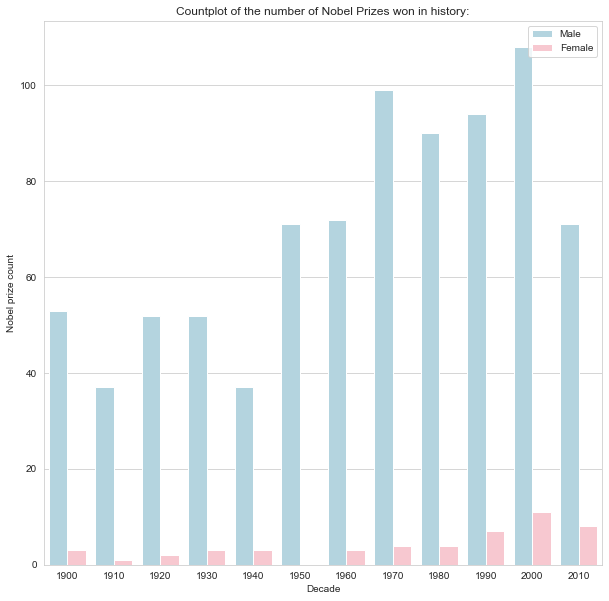

In [23]:
# Mmh, looks like the majority of winners is male, but that there is a slight increase in female laureates
fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(data=df_nobel_prizes, x='Decade', hue='Sex', palette={"Male": "lightblue", "Female": "pink"}, ax=ax)
ax.set_title(f'Countplot of the number of Nobel Prizes won in history:')
ax.set_ylabel('Nobel prize count')
ax.legend(loc='upper right')

Over the full history the share of Female Nobel prize winners has increased by 4.3% per decade.


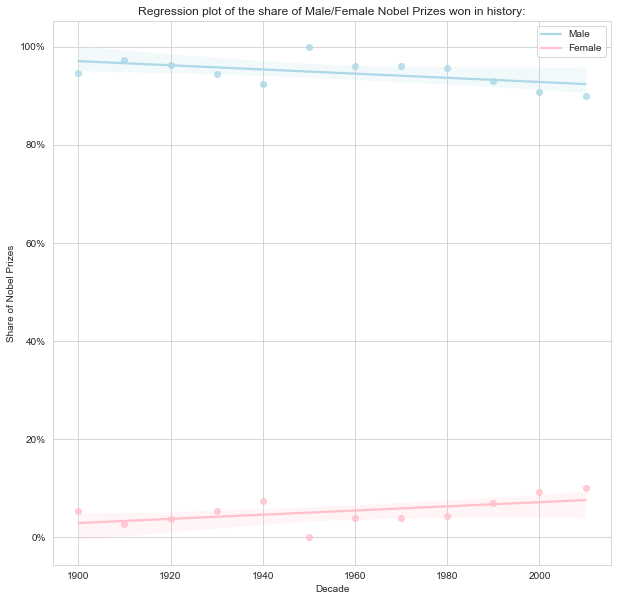

In [24]:
# The regression plot indeed indicates the share of female winners has increased over the years
pivot = pd.crosstab(df_nobel_prizes['Sex'], df_nobel_prizes['Decade'], values='Laureate ID', aggfunc='count',
                    normalize='columns')
pivot = pivot.transpose()

fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(ax=ax, data=pivot, x=pivot.index, y=pivot['Male'], color="lightblue")
sns.regplot(ax=ax, data=pivot, x=pivot.index, y=pivot['Female'], color="pink")
ax.set_title(f'Regression plot of the share of Male/Female Nobel Prizes won in history:')
ax.set_ylabel(f'Share of Nobel Prizes')
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.legend(labels=['Male', 'Female'])

# In absolute numbers the increase in female winners seems modest, where in relative numbers the regression line indicates that:
a, b = np.polyfit(pivot.index, pivot['Female'], 1)
print(f'Over the full history the share of Female Nobel prize winners has increased by {a*100:.1%} per decade.')

Over the last 4 decades the share of Female Nobel prize winners has increased by 19.9% per decade.


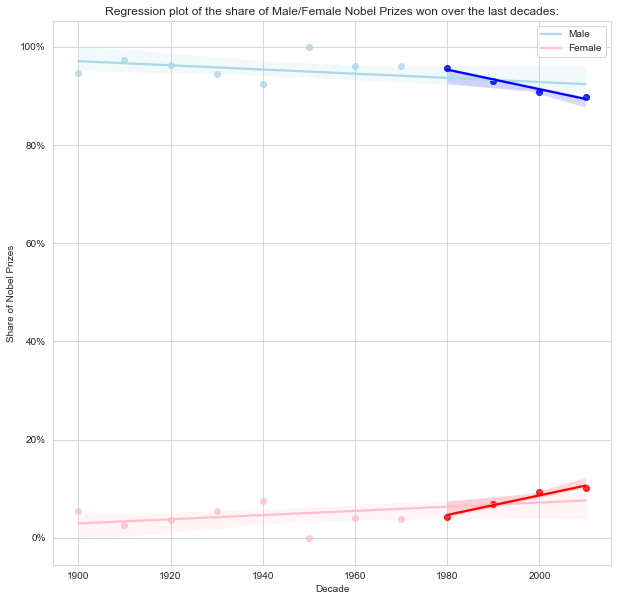

In [25]:
# Adding the regression lines for the last decades indicates the increase in share of female winners has become steeper
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(ax=ax, data=pivot, x=pivot.index, y=pivot['Male'], color="lightblue")
sns.regplot(ax=ax, data=pivot, x=pivot.index, y=pivot['Female'], color="pink")
sns.regplot(ax=ax, data=pivot, x=pivot.index[-4:], y=pivot['Male'][-4:], color="blue")
sns.regplot(ax=ax, data=pivot, x=pivot.index[-4:], y=pivot['Female'][-4:], color="red")
ax.set_title(f'Regression plot of the share of Male/Female Nobel Prizes won over the last decades:')
ax.set_ylabel(f'Share of Nobel Prizes')
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.legend(labels=['Male', 'Female'])

# In absolute numbers the increase in female winners seems modest, where in relative numbers the regression line indicates that:
a, b = np.polyfit(pivot.index[-4:], pivot['Female'][-4:], 1)
print(f'Over the last 4 decades the share of Female Nobel prize winners has increased by {a*100:.1%} per decade.')

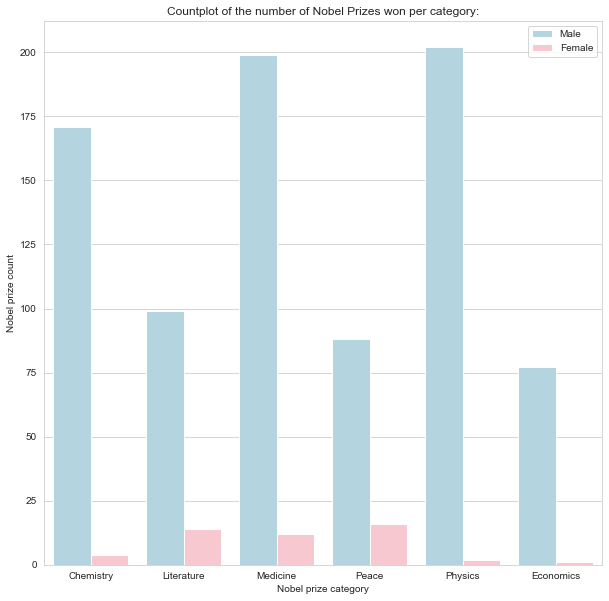

In [26]:
# Nobel prizes won by male and female laureates per category
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(x='Category', data=df_nobel_prizes, hue='Sex', palette={"Male": "lightblue", "Female": "pink"}, ax=ax)
ax.set_title(f'Countplot of the number of Nobel Prizes won per category:')
ax.set_xlabel('Nobel prize category')
ax.set_ylabel('Nobel prize count')
ax.legend(loc='upper right')

Text(0.5, 0.98, 'Countplot of the number of Nobel Prizes won in history per category:')

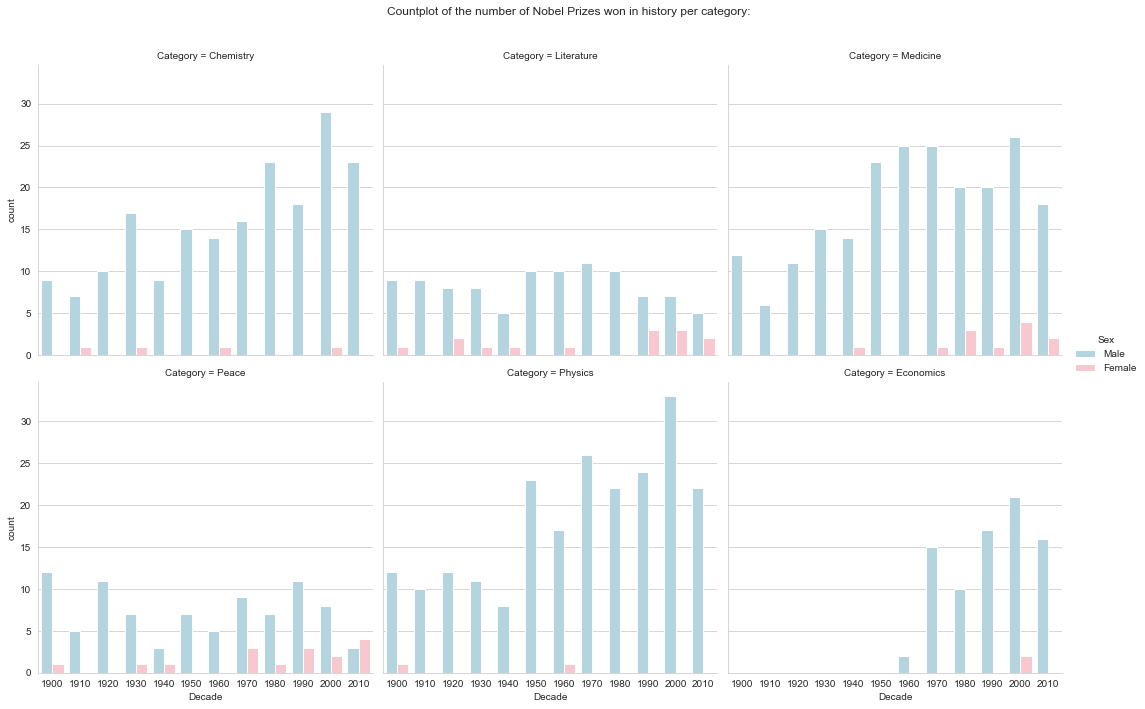

In [27]:
# Well in some categories female laureates seem to perform quite well last decade
g = sns.catplot(kind='count', data=df_nobel, x='Decade', hue='Sex', col='Category', col_wrap=3,
                  palette={"Male": "lightblue", "Female": "pink"})
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f'Countplot of the number of Nobel Prizes won in history per category:')

#### Nobel prizes by Country

#68 countries are not reflected in the world map as the country name differed over time (example: Prussia (Poland))


<AxesSubplot:title={'center':'Countplot of the number of Nobel Prizes won per country:'}>

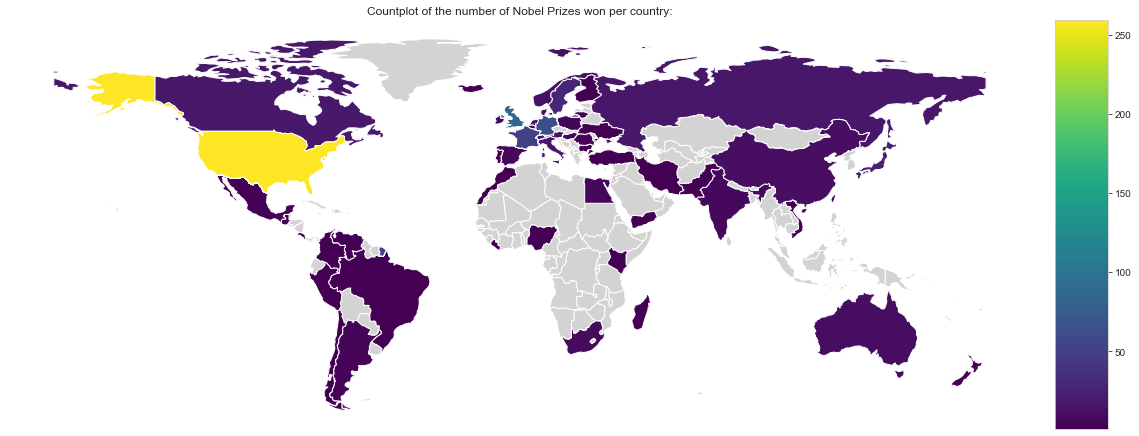

In [28]:
# Define geopandas geometry dataframe:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]  # Reflect countries with population, leaving Antartica out

# Define nobel prize dataframe:
nobel = df_nobel_prizes.drop(['Birth Date', 'Death Date'], axis = 1)  # Geopandas conflict with Date format
nobel['Nobel_Country_Count'] = df_nobel_prizes.groupby('Birth Country')['Birth Country'].transform('count')  # Derives count of Nobel prizes per Birth Country

# Merge geopandas geometry and nobel prize dataframes
df = pd.merge(nobel, world, how='left', left_on='Birth Country', right_on='name').reset_index()
df_gdf = gpd.GeoDataFrame(df)

# Identify countries of birth for which 'geometry' was not merged
countries_not_reflected = df_gdf[df_gdf['geometry'].isna()]['Birth Country'].unique()
print(f'#{len(countries_not_reflected)} countries are not reflected in the world map as the country name differed over time (example: {countries_not_reflected[0]})')

# Plot world map!
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title(f'Countplot of the number of Nobel Prizes won per country:')
ax.set_axis_off()

# Format legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='lightgrey')
df_gdf.plot(ax=ax, column='Nobel_Country_Count',cmap='viridis', legend=True, cax=cax)

[Text(0, 0, 'United States of America'),
 Text(1, 0, 'United Kingdom'),
 Text(2, 0, 'Germany'),
 Text(3, 0, 'France'),
 Text(4, 0, 'Sweden'),
 Text(5, 0, 'Japan'),
 Text(6, 0, 'Canada'),
 Text(7, 0, 'Netherlands'),
 Text(8, 0, 'Italy'),
 Text(9, 0, 'Russia')]

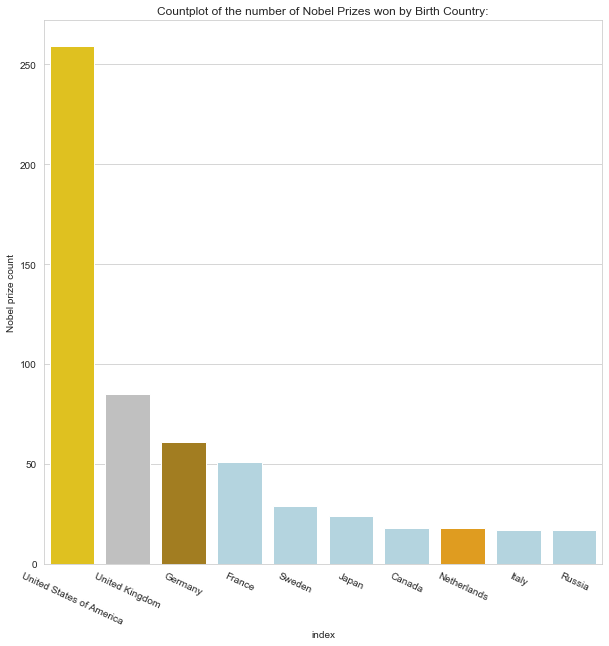

In [29]:
# The top-10 countries where most Nobel prize laureates where born?
df = df_nobel_prizes['Birth Country'].value_counts().reset_index()

# Determine medal coloring for top-3 countries with respect to Nobel prize winners
colors = {}
for index, row in df.iterrows():
    n = row['Birth Country']
    if n==df['Birth Country'][0]:
        colors[row['index']] = 'gold'
    elif n==df['Birth Country'][1]:
        colors[row['index']] = 'silver'
    elif n==df['Birth Country'][2]:
        colors[row['index']] = 'darkgoldenrod'
    elif row['index']=='Netherlands':
        colors[row['index']] = 'orange'
    else:
        colors[row['index']] = 'lightblue'
        
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=df.head(n=10), x='index', y='Birth Country', palette=colors, ax=ax)
ax.set_title(f'Countplot of the number of Nobel Prizes won by Birth Country:')
ax.set_ylabel('Nobel prize count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-25)

In [43]:
def country_rank(df, country):
    """Counts number of Nobel prizes awarded by 'Birth Country'"""
    countries = df['Birth Country'].unique()
    df = df['Birth Country'].value_counts().reset_index()
    df = df[df['index'] == 'Netherlands'].reset_index()  # Index number +1 is rank
    df.set_axis(['Rank', 'Country', 'Count'], axis=1, inplace=True)
    if len(df.index) == 1:
        c = df.loc[0, 'Country']
        i = df.loc[0, 'Rank']
        n = df.loc[0, 'Count']
        print(f'Country: {c} is ranked at place {i + 1} with #{n} Nobel prize winners')
    else:
        print(f'No valid records retrieved for: {country}, please submit any of the following countries: {countries}')

# How does your country rank with respect to Nobel prize laureates?
country_rank(df_nobel_prizes, country='Netherlands')

Country: Netherlands is ranked at place 8 with #18 Nobel prize winners


#### Nobel prizes by Age

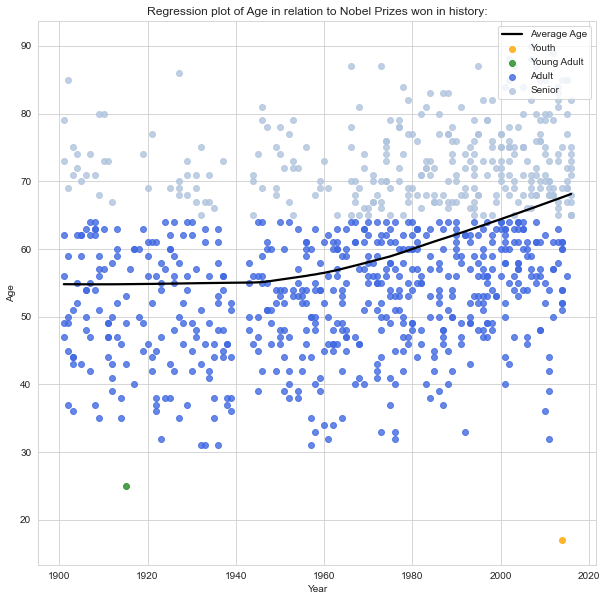

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(ax=ax, data=df_nobel_prizes, x='Year', y='Age', scatter=False, lowess=True, line_kws={'color': 'black'})
sns.regplot(ax=ax, data=df_nobel_prizes[df_nobel_prizes['Age_Group'] == 'Youth']
            , x='Year', y='Age', lowess=True, fit_reg=False, color="orange")
sns.regplot(ax=ax, data=df_nobel_prizes[df_nobel_prizes['Age_Group'] == 'Young Adult']
            , x='Year', y='Age', lowess=True, fit_reg=False, color="forestgreen")
sns.regplot(ax=ax, data=df_nobel_prizes[df_nobel_prizes['Age_Group'] == 'Adult']
            , x='Year', y='Age', lowess=True, fit_reg=False, color="royalblue")
sns.regplot(ax=ax, data=df_nobel_prizes[df_nobel_prizes['Age_Group'] == 'Senior']
            , x='Year', y='Age', lowess=True, fit_reg=False, color="lightsteelblue")

ax.set_title(f'Regression plot of Age in relation to Nobel Prizes won in history:')
ax.legend(labels=['Average Age', 'Youth', 'Young Adult', 'Adult', 'Senior'], loc='upper right')

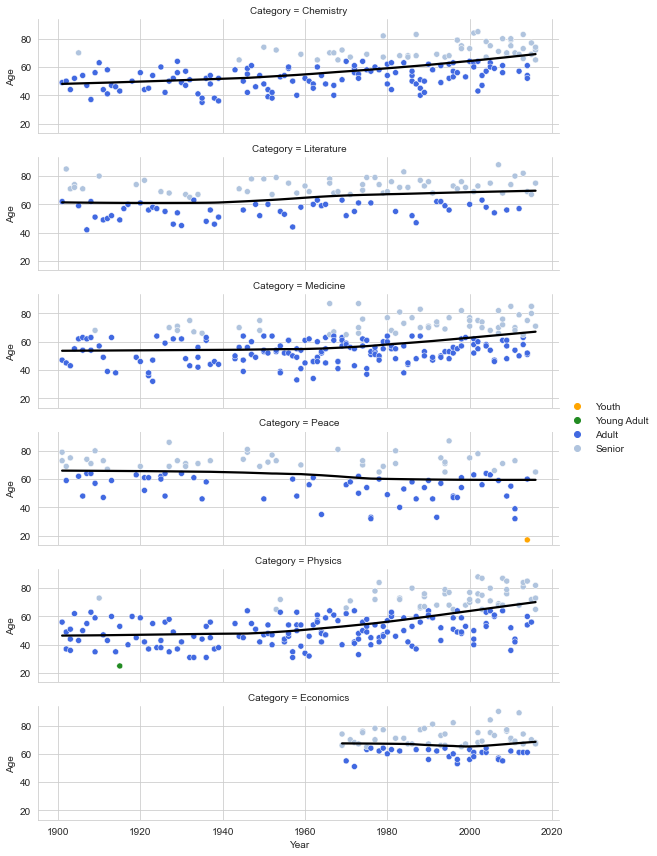

In [32]:
# The trend in age is clearly increasing for nobel prize winners, though we see some differences across the prize categories
g = sns.FacetGrid(df_nobel_prizes, row='Category', height=2, aspect=4)
g.map_dataframe(sns.regplot, x='Year', y='Age', scatter=False, lowess=True, line_kws={'color': 'black'})  # Only Lowess for Male/Female combined
g.map_dataframe(sns.scatterplot, x='Year', y='Age', hue='Age_Group', palette={"Youth": "orange", "Young Adult": "forestgreen", "Adult": "royalblue", "Senior": "lightsteelblue"})
g.add_legend()

In [33]:
# The oldest winner of a Nobel Prize as of 2016
df_nobel_prizes.nlargest(1, "Age")

,Year,Category,Prize,Motivation,Prize Share,Laureate ID,Laureate Type,Full Name,Birth Date,Birth City,...,Organization Name,Organization City,Organization Country,Death Date,Death City,Death Country,Decade,Age,Age_Group,Generation
825,2007,Economics,The Sveriges Riksbank Prize in Economic Scienc...,"""for having laid the foundations of mechanism ...",1/3,820,Individual,Leonid Hurwicz,1917-08-21,Moscow,...,University of Minnesota,"Minneapolis, MN",United States of America,2008-06-24,"Minneapolis, MN",United States of America,2000,90.0,Senior,Greatest Generation


In [34]:
# The youngest winner of a Nobel Prize as of 2016
df_nobel_prizes.nsmallest(1, "Age")

,Year,Category,Prize,Motivation,Prize Share,Laureate ID,Laureate Type,Full Name,Birth Date,Birth City,...,Organization Name,Organization City,Organization Country,Death Date,Death City,Death Country,Decade,Age,Age_Group,Generation
940,2014,Peace,The Nobel Peace Prize 2014,"""for their struggle against the suppression of...",1/2,914,Individual,Malala Yousafzai,1997-07-12,Mingora,...,NaN,NaN,NaN,NaN,NaN,NaN,2010,17.0,Youth,Generation Z


#### Nobel prizes by Generation

Text(0.5, 1.0, 'Boxplot of Generation in relation to Nobel Prizes won in history:')

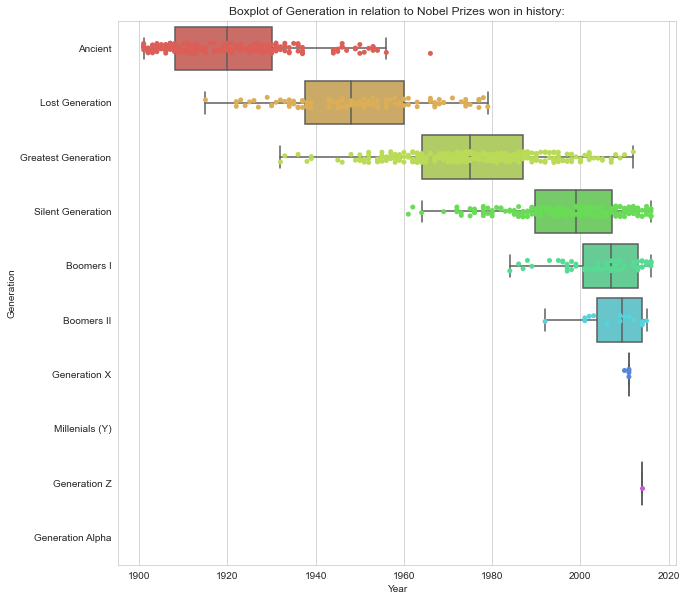

In [35]:
# Lets also have a look at the Nobel laureates per generation
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(ax=ax, data=df_nobel_prizes, x='Year', y='Generation',fliersize=0, palette="hls")
sns.stripplot(ax=ax, data=df_nobel_prizes, x='Year', y='Generation', palette="hls")
ax.set_title(f'Boxplot of Generation in relation to Nobel Prizes won in history:')

#### Repeat laureates

In [36]:
repeat_laureates = df_nobel_prizes.groupby('Full Name').filter(lambda winner: len(winner) > 1)
display(repeat_laureates[['Full Name', 'Birth Country', 'Laureate Type']].value_counts().to_frame())

,,,0
Full Name,Birth Country,Laureate Type,
Frederick Sanger,United Kingdom,Individual,2
John Bardeen,United States of America,Individual,2
Linus Carl Pauling,United States of America,Individual,2
"Marie Curie, née Sklodowska",Russian Empire (Poland),Individual,2
